---

# 12.4 Generating images with variational autoencoders

In [2]:
import os
import sys
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

---

## 12.4.1 Sampling from latent spaces of images

Many times we have seen that **information bottlenecks** can be a problem for us.

This time, we want to turn those to our advantage!

Imagine if we could compress images to a **lower-dimensional space**, a **latent space**, with good properties.

In such a space, each point (coordinate) would corresponds to a realistic image!

<!-- <img style="height:600px" src="images/vae/chollet.latent-space-sampling.p.392.png"> -->
<img style="height:600px" src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/chollet.latent-space-sampling.p.392.png?raw=true">

<small>DLWP, p.392</small>


A *generator* or *decoder* module (in a GAN or a VAE, respectively) transforms a point in the latent space back to the source distribution, in our case: images.

Any point in the latent space can be sampled.

The sampling and reconstruction process means that new, never seen before, yet (hopefully) realistic, images can be created.

<!-- <img src="images/vae/chollet.latent-space-continuous.p.392.png"> -->
<img style="height:400px" src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/chollet.latent-space-continuous.p.392.png?raw=true">

<small>DLWP, p.392</small>


GANs and VAEs generate latent spaces in different ways.

VAEs are good at generating **structured latent spaces** where specific directions encode meaningful data.

GANs generate **very realistic images** but the latent space may **not be so structured** and is less useful for image editing.

---

## 12.4.2 Concept vectors for image editing

Similar to embeddings: inside the embedded space, you can do vector math with meanings!

```python
Tokyo - Japan + China = Beijing
```

<!-- <img style="height:400px" src="images/nlp/linear-relationships.svg"> -->
<img style="height:400px" src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/nlp/linear-relationships.svg?raw=true">

<small>[Embeddings: Translating to a Lower-Dimensional Space, Google Foundational Courses, Machine Learning, Embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space)</small>

Different vectors / dimensions encode interesting properties, e.g. a **'smile' vector**.

If you have found a smile vector, you can project an image into the latent space, add a smile vector, and then decode.

The resulting image will have more 'smile' inside it.

Concept vectors naturally emerge for many properties  e.g. sunglasses, beards, etc...

<!-- ![Chollet, concept vector](images/vae/chollet.concept-vector.p.393.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/chollet.concept-vector.p.393.png?raw=true">

<small>DLWP, p.393</small>

---

## 12.4.3 Variational autoencoders

A **classic autoencoder** maps an image to a low dimensional fixed code (a vector) and then decodes back to the original space.

The autoencoder learns a kind of compression, and
The autoecoder then learns by comparing its decoded output with the input. It is **self-supervised**!

But these classic spaces are not structured in a useful way, *and* it's **deterministic**!

<!-- ![Autoencoder](images/vae/autoencoder.jpg) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/autoencoder.jpg?raw=true">

<small>DLWP, p.394</small>

**Variational autoencoders** do not compress data into a fixed code in the latent space, but learn the **parameters of a probability distribution** (its mean and variance).

The assumption is that the output image is the result of a statistical process.  
(The randomness of this process should be taken into account during encoding and decoding.)

The randomness (stochasticity) as well as the specific loss used improve robustness and forces the latent space to encode meaningful representations everywhere.

<!-- ![VAE](images/vae/vae.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/vae.png?raw=true">


<small>DLWP, p.395</small>

##### Workflow

1. The encoder module maps an input image to a *mean* $\mu$ and a *variance* $\sigma$;
2. We randomly sample: $z \sim \mathcal{N}(\mu, \sigma^2)$ i.e. $z \sim \mu + \sigma \cdot \mathcal{N}(0, 1)$;
3. The decoder module maps $z$ back to the original image space.

### The loss functions

1. The **reconstruction loss**: forces the decoded samples to match the initial inputs;
2. The **regularisation loss**: ensures well-formed latent spaces and minimal overfitting.

The stochastic sampling means that slightly different latent vectors will be generated from the same source.

The decoder is attempting to decode all the random latent vectors emanating from the same source to the same target (which is identical to the source!).

=> neighbouring points in the latent space are decoded to the same image.



### Sampling from a normal distribution

$$
\bbox[5px,border:2px solid red]{
\begin{aligned}
z \sim & \mathcal{N}(\mu, \sigma^2)\\
& & \text{can be performed like so:}\\
z \sim & \mu + \sigma \mathcal{N}(0, 1)
\end{aligned}
}
$$

$z$: sample  
$\mu$: mean  
$\sigma^2$: variance, $\sigma$: standard deviation  
$N$: normal distribution  

You can think of $\mu$ as a point in the latent space and $\sigma$ defining an area around this point.

The **regularisation loss** ensures that the $z$'s are clustered together at the centre of the latent space.

The $\sigma$ areas overlap so that a continuous and structured representation is built.

That representation is densely packed, so that any sampled point from it should yield a new valid data point.

New images are generated by decoding a selected point $z$ in the latent space.

### VAE: the maths

We want to learn ways to transform the intractable (and unknown) underlying probability distribution of the data ($p(x)$, $x$ stands for a sample) into one that is known, tractable, easy to sample from (like a Gaussian distribution, for instance). The latter one will be the distribution of our latent space, and is called the **prior** in Bayesian statistics parlance (as it is _our_ presuppositions, as it were, our choice), and is denoted $p_{\theta}(z)$, with $\theta$ being parameters ($\mu$ and $\sigma^2$ are parameters of a Gaussian, our weights and biases are parameters of our complext approximator, the neural network).

We want to be able to sample from this prior distribution, to get a $z$ from our latent space, then use this $z$ in combination with our **Decoder** $p_{\theta}(x|z)$ to generate a new data sample.

In order for the training procedure to work, we also need to be able to go the other way, from data space to $z$ space: in theory, that would require the  **posterior** distribution ($p_{\theta}(z|x)$), which is unknown/intractable. But we can learn an approximation of it, $q_{\phi}(z|x)$, which will be our **Encoder** ($\phi$ are different parameters).

<!-- ![Kingma VAE figure](images/vae/kingma.vae.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/kingma.vae.png?raw=true">


Source: [Kingma et al, "An Introduction to Variational Autoencoders"](https://arxiv.org/abs/1906.02691), p. 17

#### The reparametrization trick

However, we don't just want a deterministic mapping, but a stochastic one, which creates issues with backpropagation! That's where the main contribution of Kingma et al

$$
\begin{aligned}
z & \sim q_{\phi}(z | x), \text{which is reparameterised (the ``reparametrisation trick"):}\\
\\
z & \sim g(\phi, x, \epsilon), \text{ which performs }\\
\\
\mu, \sigma  & \sim q'_{\phi}(x), \text{ then }\\
\\
z & = \mu + \sigma \odot \epsilon, \text{ with } \epsilon \sim \mathcal{N}(0, \mathbf{I})
\end{aligned}
$$

$q$ is our approximation of the intractable posterior $p(z|x)$, that would go from data space to $z$ space.

To make our whole system differentiable, we make the encoder $q'$ predict the mean and variance (log variance, for numerical stability) of the latent variable $z$, and then inject randomness "from the outside" using $\epsilon$.

$\phi$ denotes the parameters of the net.

<!-- ![reparametrization trick figure](images/vae/kingma.reparametrisation-trick.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/kingma.reparametrisation-trick.png?raw=true">


Source: [Kingma et al, "An Introduction to Variational Autoencoders"](https://arxiv.org/abs/1906.02691), p. 22

#### The loss function: reconstruction & KL divergence

##### The ELBO

As previously mentioned, ultimately we want $\log p_{\theta}(x)$, which is intractable. When conditioning on $z$, that becomes more possible, and the following manipulations yield a loss term that we can work with, the **evidence lower bound** (aka ELBO):

$$
\begin{aligned}
\log p_{\theta}(x) & = \log \int p_{\theta}(x, z) dz & {\tiny \text{(`demarginalise' our latent variable)} }\\
& = \log \int \frac{ q_{\phi}(z|x) }{ q_{\phi}(z|x) } p_{\theta}(x, z) dz & { \tiny \text{(inject the encoder } q_{\phi} \text{, amounts to multiplying by 1)}} \\
& = \log \int \frac{ p_{\theta}(x, z)  }{ q_{\phi}(z|x) } q_{\phi}(z|x)dz & { \tiny \text{(now looking like an expection w.r.t. } q_{\phi}) }  \\
& = \log \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \frac{ p_{\theta}(x, z)  }{ q_{\phi}(z|x) } \right] \\
& \geq \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log  \frac{ p_{\theta}(x, z)  }{ q_{\phi}(z|x) } \right] := \operatorname{ELBO}  & { \tiny \text{(applying Jensen's inequality, with log being concave)} }
\end{aligned}
$$

Why is this called the ELBO? In Bayesian statistics parlance, the $\log p_{\theta}(x)$ term is called the _evidence_. As the $\geq$ sign indicates, ELBO is a lower bound on it (and we will try to maximise it).

What is more, if you rewrite the above, you obtain:

$$
\begin{aligned}
\operatorname{ELBO} & = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log \frac{ p_{\theta}(x, z)  }{ q_{\phi}(z|x) } \right] \\
& =  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log p_{\theta}(x, z)  - \log q_{\phi}(z|x)  \right] \\
& =  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \underbrace{ \log p_{\theta}(z|x) p_{\theta}(x) }_{ \tiny \text{ definition of joint prob} } - \log q_{\phi}(z|x)  \right] \\
\\
& =  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log p_{\theta}(z|x) + \log p_{\theta}(x) - \log q_{\phi}(z|x)  \right] \\
\\
& = \underbrace{ \log p_{\theta}(x) }_{ \tiny \substack{ \text{does not dependent on } z, \\ \mathbb{E} \text{ goes away} } } +  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log p_{\theta}(z|x)  - \log q_{\phi}(z|x) \right] \\
& = \log p_{\theta}(x) +  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log \frac{ p_{\theta}(z|x) }{ q_{\phi}(z|x)  } \right] \\
\\
& = \log p_{\theta}(x) - \underbrace{ \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log \frac{ q_{\phi}(z|x)  }{ p_{\theta}(z|x) } \right] }_{ \text{ def. of KL divergence} } \\
\\
& = \underbrace{ \log p_{\theta}(x) }_{ \text{evidence} } -  D_{KL} ( q_{\phi}(z|x)  | p_{\theta}(z|x) ) \\
\end{aligned}
$$

Otherwise put:

$$
\begin{aligned}
\log p_{\theta}(x) & = \operatorname{ELBO} +  D_{KL} ( q_{\phi}(z|x)  | p_{\theta}(z|x)) & { \small D_{KL} \text{ always positive} } \rightarrow \\
\log p_{\theta}(x) & \geq \operatorname{ELBO} & { \small \text{ELBO as lower bound} }
\end{aligned}
$$

What this means is that the gap between the ELBO and $p_{\theta}$ is exactly the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), KL divergence for short, between $p_{\theta}$ and $q_{\phi}$, which means that maximising the ELBO indirectly minimises the KL divergence (which is what we want):

<!-- ![ELBO D KL gap](images/vae/Bernstein.ELBO-evidence-gap.png) -->

<img src="https://github.com/jchwenger/AI/blob/main/lectures/08/images/vae/Bernstein.ELBO-evidence-gap.png?raw=true">


Source: [Matthew M. Bernstein, "The evidence lower bound (ELBO)"](https://mbernste.github.io/posts/elbo/)

##### Two-terms loss

Now that we know that maximising the ELBO will perform the optimisation we need, it is actually possible to break it down into two terms:

$$
\begin{aligned}
\operatorname{ELBO} & = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log \frac{ p_{\theta}(x, z)  }{ q_{\phi}(z|x) } \right] \\
\\
& = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log p_{\theta}(x, z)  - \log  q_{\phi}(z|x)  \right] \\
\\
& = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \underbrace{ \log p_{\theta}(x | z) + \log p_{\theta}(z) }_{ \small \text{definition of joint prob.} }  - \log  q_{\phi}(z|x)  \right] \\
\\
& = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log p_{\theta}(x | z) \right] +  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log p_{\theta}(z)  - \log  q_{\phi}(z|x)  \right] \\
\\
& = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log p_{\theta}(x | z) \right] +  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log  \frac { p_{\theta}(z) }{   q_{\phi}(z|x) }  \right] \\
\\
& = \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[ \log p_{\theta}(x | z) \right] -  \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log  \frac { q_{\phi}(z|x) }{ p_{\theta}(z) }  \right] \\
\\
& = \underbrace{ \mathbb{E}_{z\sim q_{\phi}(\cdot|x)} \left[  \log p_{\theta}(x | z)  \right] }_{  \small \substack{ \text{log likelihood  of} \\ \text{data given  latent } z \\ \rightarrow \text{ reconstruction loss!} } } - \underbrace{ D_{KL}( q_{\phi}(z|x) | p_{\theta}(z) ) }_{ \small \text{keep } q_{\phi}(z|x) \text{ close to } p_{\theta}(z) } := \mathcal{L}(\theta, \phi, x)  \\
\end{aligned}
$$

##### Term one: log likelihood

For the first term, we construct the loss in the same way as we did in problems like sentiment: we treat each pixel value as if that was a sample from the distribution we seek to approximate, and we use them a label (between 0 and 1), while our model outputs $log p_{\theta}(x|z)$, a probability value. We can apply the same logic as before, and use the binary cross-entropy loss between the model output for each pixel and the original image.

##### Term two: KL divergence

When our prior $p_{\theta}(z)$ is set to be Gaussian, the $D_{KL}$ term can be solved analytically (without requiring sampling), like so:

$$
\mathcal{L}(\theta, \phi, x) = \underbrace{ \frac{1}{2} \cdot \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right) }_{ \substack{ D_{KL}(q_{\phi}(z|x)| p_{\theta}(z))\\ (\text{make sure } q_{\phi}(z|x) \text{ stays close to } p_{\theta}(z) = \mathcal{N}(0, 1) ) }\\ } + \underbrace{ \log p_{\theta}(x|z) }_{ \text{reconstruction loss} }
$$

For the derivation, see [the paper](https://arxiv.org/pdf/1312.6114.pdf), p. 5, and Appendix B, pp. 10-11.


We minimise the loss, therefore we add a negative sign.

```python
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#                     ↑ log(var)  ↑ mean^2            ↑ exp and log cancel: only var
```



---

## 12.4.4 Implementing a VAE with Keras

### VAE encoder network

In [2]:
latent_dim = 2
def build_encoder(latent_dim=2):
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)               # MEAN
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)         # LOG OF VARIANCE = log(sigma**2)
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder") # (log for math/stability)
encoder = build_encoder(latent_dim=latent_dim)

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

### Latent-space-sampling layer

In [4]:
class Sampler(tf.keras.layers.Layer):
    """From a mean mu and a log variance, sample a number with mu + sigma * epsilon"""
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size)) # epsilon, a vector of random numbers
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon      # this is equivalent to mu + sigma * epsilon

#### Examining our sampler

In [5]:
# Why the above formula works?

std = 1.4
var = std**2
log_var = np.log(var)
print(f"std: {std}")
print(f"var: {var}")
print(f"log var: {log_var}")
print(f"and back to std: {np.exp(0.5 * log_var)}")
print()
print("The log and the exp functions are reciprocal,")
print("and 0.5 * log(var) == log(var ** 0.5) == log(sqrt(var)).")
print()
print("0.5 * log_var == np.log(np.sqrt(var))?", np.allclose(0.5 * log_var, np.log(np.sqrt(var))))

std: 1.4
var: 1.9599999999999997
log var: 0.6729444732424257
and back to std: 1.4

The log and the exp functions are reciprocal,
and 0.5 * log(var) == log(var ** 0.5) == log(sqrt(var)).

0.5 * log_var == np.log(np.sqrt(var))? True


### VAE decoder network, mapping latent space points to images

In [6]:
def build_decoder(latent_dim=2):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # CONV 2D TRANSPOSE
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = tf.keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    return tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder = build_decoder(latent_dim=latent_dim)

In [7]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

#### Note: transposed convolutions

[`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) docs. See also [this article](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d), and especially [that paper](https://arxiv.org/abs/1603.07285) ([github](https://github.com/vdumoulin/conv_arithmetic)).

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://github.com/jchwenger/AI/blob/main/lectures/08/images/deconv/deconv.1.png?raw=true)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://github.com/jchwenger/AI/blob/main/lectures/08/images/deconv/deconv.2.png?raw=true)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

### VAE model with a custom `train_step()`

In [8]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:                                    # 1. GENERATION
            z_mean, z_log_var = self.encoder(data)                         #   a. encode to mean & log var
            z = self.sampler(z_mean, z_log_var)                            #   b. a batch of random numbers
            reconstruction = decoder(z)                                    #   c. decode into reconstructed images

            reconstruction_loss = tf.reduce_mean(                          # 2. LOSSES
                tf.reduce_sum(                                             #   a. reconstruction_loss: BCE
                    tf.keras.losses.binary_crossentropy(data, reconstruction), #  between data & reconstructions
                    axis=(1, 2) # BCE is performed on each pixel, then we sum across
                )               # all pixels for each sample separately, then average
            )
                                                                           #   b. KL divergence (regularisation loss)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # (→ the latent distribution
                                                                                     # is close to a Gaussian)

            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)     #   c. total

        grads = tape.gradient(total_loss, self.trainable_weights)          # 3. BACKPROP
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) #   a. compute & apply gradients

        self.total_loss_tracker.update_state(total_loss)                   #   b.update our metrics trackers
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


### Training the VAE

Note that in this particular case, Chollet uses the entire data, including the test set: however, it is perfectly possible to keep the split, split the training set into `partial_train` and `validation`, a apply all the tools we have seen for hyperparameter tuning!

In [9]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255 

In [14]:
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=tf.keras.optimizers.Adam(),
    run_eagerly=True,
)

batch_size = 128
vae.fit(
    mnist_digits,
    epochs=30,
    batch_size=batch_size,
)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 153ms/step - kl_loss: 2.8661 - reconstruction_loss: 243.6083 - total_loss: 246.4744
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 120s 132ms/step - kl_loss: 3.4197 - reconstruction_loss: 168.1565 - total_loss: 171.5762
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 77s 140ms/step - kl_loss: 3.6036 - reconstruction_loss: 157.8839 - total_loss: 161.4874
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - kl_loss: 3.7848 - reconstruction_loss: 152.8654 - total_loss: 156.6502
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - kl_loss: 3.8419 - reconstruction_loss: 150.8397 - total_loss: 154.6816
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 133ms/step - kl_loss: 3.8731 - reconstruction_loss: 149.4756 - total_loss: 153.3486
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 131ms/step - kl_loss: 3.8928 - reconstruction_loss: 148.5080 - total_loss: 152.4008
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - kl_loss: 3.9023 - reconstruction_loss: 147.268

### Save models to Google Drive


In [ ]:
EXPORT=False

if EXPORT:
    # zip models
    !zip vae.models.zip {MODELS_DIR}/*
    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy zip to drive (adjust folder as needed)
    !cp vae.models.zip drive/MyDrive/IS53024B-Artificial-Intelligence/models

### Use your trained model

You can download the model I trained [here](https://drive.google.com/file/d/1Q_JVhfWR-VkjVP5TrMvkKjnE5E51l_yH/view?usp=sharing), for instance using `gdown` (no install needed on Colab):

```bash
!gdown [file id in url]
!unzip vae-mnist.models.zip
```

This will unzip the model to `models`, which works with the present code.

In [ ]:
IMPORT=False # true to load

if IMPORT:
    # you must have defined a model beforehand
    # vae = VAE(encoder, decoder)
    vae.load_weights(MODELS_DIR / "vae-mnist.weights.h5")

### Sampling a grid of images from the 2D latent space

In [15]:
from IPython.display import clear_output

def plot_latent_space(vae):
    n = 30
    img_size = 28
    figure = np.zeros((img_size * n, img_size * n))              # empty pixels

    grid_x = np.linspace(-1, 1, n)                               # linearly spaced values for x
    grid_y = np.linspace(-1, 1, n)[::-1]                         # linearly spaced values for y

    tot = len(grid_y) * len(grid_x)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            clear_output(wait=True)
            print(f"{i*len(grid_y) + j + 1}/{tot}")
            z_sample = np.array([[xi, yi]])                      # 1. sample at (xi, yi) coordinate
            x_decoded = vae.decoder.predict(z_sample, verbose=0) # 2. decode image from sample
            img = x_decoded[0].reshape(img_size, img_size)       # 3. include image into our grid
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = img

    plt.figure(figsize=(15, 15))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")

900/900


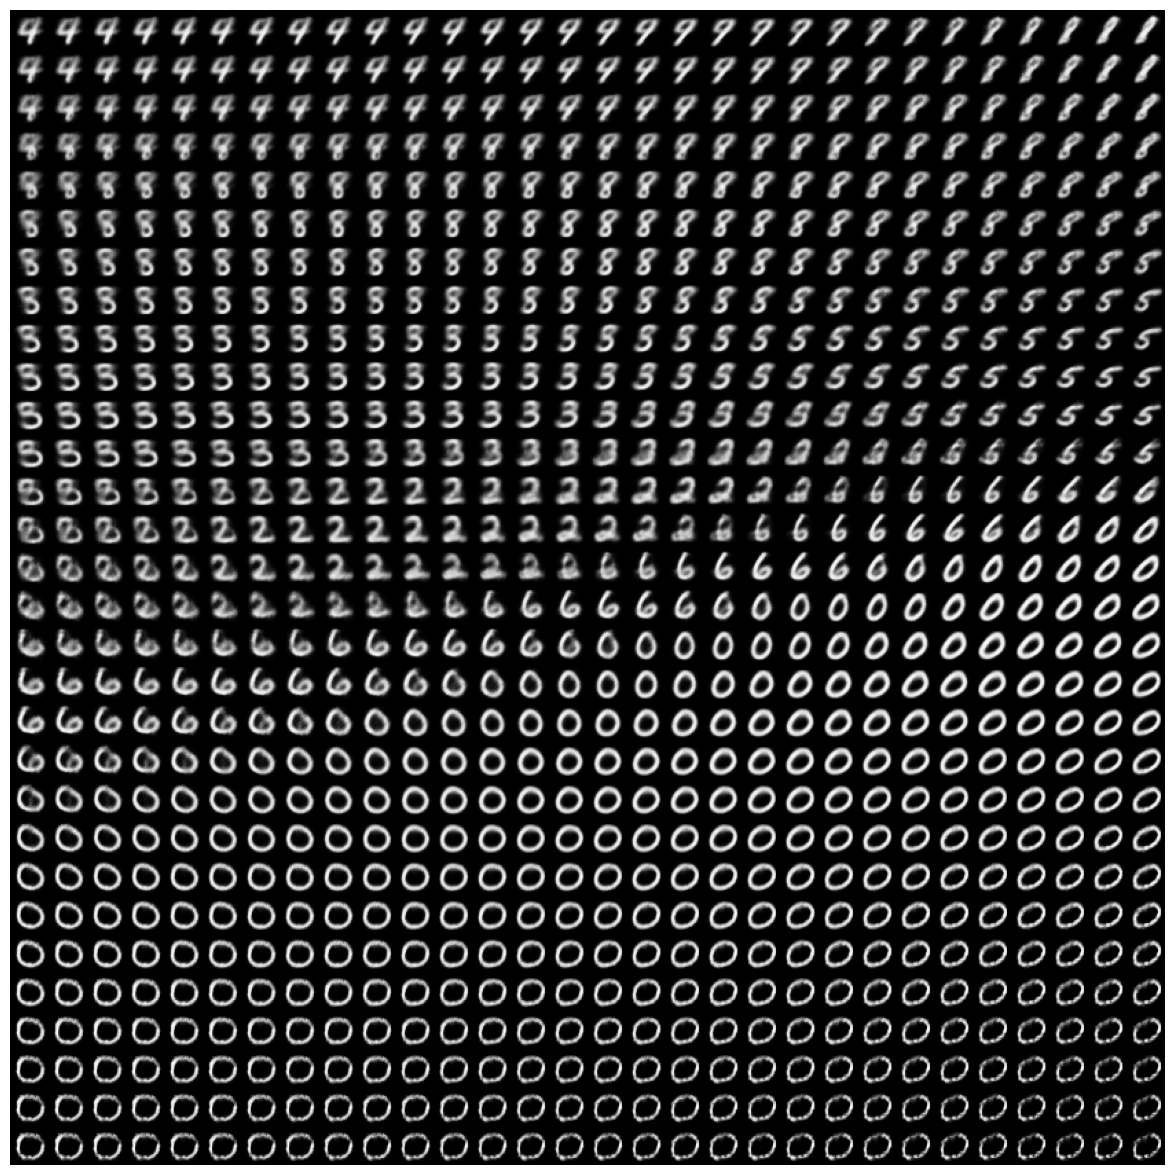

In [16]:
plot_latent_space(vae)

---

## 12.4.5 Wrapping up

- **Encoding**: we learn a **latent spaces** capturing statistical information about a dataset of images;
- **Decoding**: new images are produced by sampling and decoding points from the latent space;
- The latent space **compresses** the data in a way that is not dissimilar to **word embeddings**;

Two major approaches to do this: **Variational Autoencoders** (VAEs) and **Generative Adversarial Networks** (GANs).

### VAEs

- **VAEs** result in **highly structured, continuous latent representations**;
- They work well for **image editing in latent space**: face swapping, turning a frowning face into a smiling face, and so on;
- VAEs also work nicely for **latent-space-based animations** e.g. a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way.

### GANs

- GANs generate **(very) realistic single-frame images** but
- only **implicitly** create latent spaces, and
- not necessarily spaces with solid structure and high continuity.

### Further experiments

- Train on other datasets. For instance, you could try the **Celeb Faces Attributes** (CelebA) dataset, or FashionMNIST, instead of MNIST. It’s a free-to-download image dataset containing more than 200,000 celebrity portraits. Available in the external [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/celeb_a) module, [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) and the [original project page](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). See the GAN notebook!
- **Interpolation**: one way to visualise a 'path' between two images is to encode each image to get `z_1` and `z_2`, their respective latent vectors. Then use function to create a series of [interpolated vectors between the two](https://github.com/soumith/dcgan.torch/issues/14#issuecomment-525160139): then, decode all these using the decoder, and plot the results, which should be a smooth-ish transition between the two images, with each intermediate image still being close to the dataset!
- **Feature vectors**: in order to isolate and work with a **smile vector** (or any other feature vector), the strategy is as follows:
  - gather as many examples of images with, and without, the desired feature, as possible;
  - for each of those, use the encoder to generate a vector `z`;
  - average the values of all vectors with and without the feature into two vectors: `avg_z_with`, `avg_z_without`;
  - to get the vector that moves from 'without' to 'with' the feature, compute: `z_feature = avg_z_with - avg_z_without`;
  - now you should be able to edit an image, by encoding it using the encoder, into `z_img`, then adding the feature vector to it (you can use some scaling to vary the strength of the modification): `z_img_modified = z_img + scale_factor * z_feature`;
  - finally, use the decoder to generate an image from `z_img_modified`.
- Have a look at the 'extract_attrib_vector' function [here](https://github.com/eduhrami/Hands-On-Image-Generation-with-TensorFlow-2.0/blob/master/Chapter02/ch2_vae_faces.ipynb) (it uses label logic from CelebA, but you could select the images your self). See also [this notebook](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb) and its [utils](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_utils.py).